# Demo Pose Estimation

In [1]:
import cv2
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd
import numpy as np

from network.rtpose_model import get_model
from network.post import decode_pose
from training.datasets.coco_data.preprocessing import vgg_preprocess
from network import im_transform
from evaluate.coco_eval import get_multiplier, get_outputs, handle_paf_and_heat



### Loading pre-trained symbolic model

In [2]:
net = get_model('mobilenet')
ctx = mx.gpu(0)
net.collect_params().reset_ctx(ctx)
net.load_parameters('model_checkpoints/nb_bn_dropout2_ft_mobilenet_pose_ft_5_float32.params', ctx=ctx)

In [3]:
SIZE = 368 
net.hybridize(static_shape=True, static_alloc=True)

In [4]:
%%time
out, _ = net(mx.nd.ones((1, 3, SIZE, SIZE), dtype='float32', ctx=ctx)) #warm-up
out[0].wait_to_read()

CPU times: user 516 ms, sys: 340 ms, total: 856 ms
Wall time: 1.21 s


## Detecting pose on sample image

In [5]:
test_image = './readme/anton.png'
img = cv2.imread(test_image) # B,G,R order

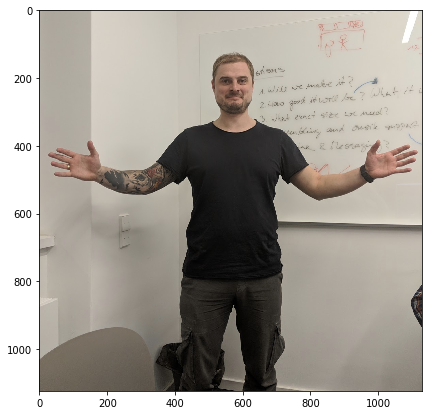

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(img[:,:,::-1])

In [7]:
%%time
img = cv2.resize(img, (368,368))
shape_dst = np.min(img.shape[0:2])

CPU times: user 24 ms, sys: 44 ms, total: 68 ms
Wall time: 7.74 ms


In [8]:
%%time 
# Get results of original image[
multiplier = [0.6]


orig_paf, orig_heat = get_outputs(multiplier, img, net,  'vgg', ctx=ctx)
          
# Get results of flipped image
#swapped_img = img[:, ::-1, :]
#flipped_paf, flipped_heat = get_outputs(multiplier, swapped_img, net, 'vgg', ctx=ctx)

# compute averaged heatmap and paf
#paf, heatmap = handle_paf_and_heat(orig_heat, flipped_heat, orig_paf, flipped_paf)
            
param = {'thre1': 0.05, 'thre2': 0.05, 'thre3': 0.05}
canvas, to_plot, candidate, subset = decode_pose(img, param, orig_heat, orig_paf)

CPU times: user 312 ms, sys: 300 ms, total: 612 ms
Wall time: 668 ms


Results

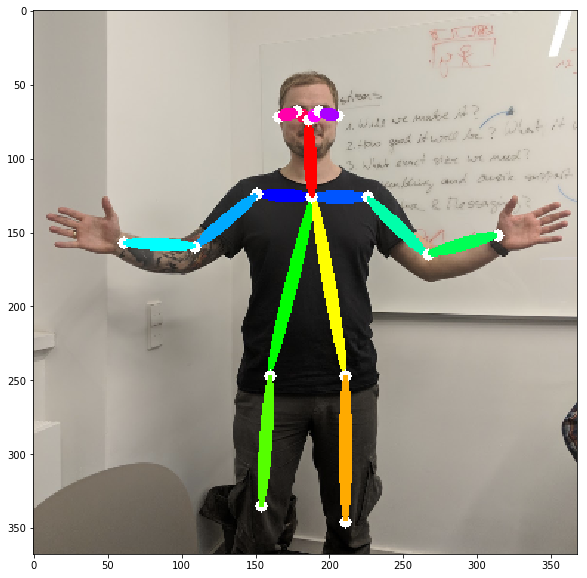

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(to_plot[:,:,::-1])

In [10]:
ctx_hm = mx.gpu(2)

In [11]:
transform = mx.gluon.data.vision.transforms.Compose(
    [
        mx.gluon.data.vision.transforms.Resize(SIZE, True),
        mx.gluon.data.vision.transforms.CenterCrop(SIZE, cv2.INTER_CUBIC),
        mx.gluon.data.vision.transforms.ToTensor(),
        mx.gluon.data.vision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [12]:
model_heatmap = gluon.nn.SymbolBlock.imports(
    symbol_file='model_checkpoints/export_mobilenet_heatmap-symbol.json',
    param_file='model_checkpoints/export_mobilenet_heatmap-0000.params',
    input_names=['data'],
    ctx=ctx_hm)

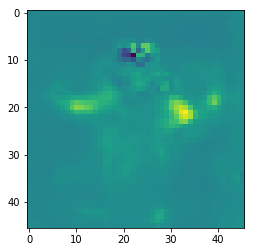

In [13]:
plt.imshow(model_heatmap(transform(mx.image.imread(test_image)).expand_dims(axis=0).as_in_context(ctx_hm))[0].asnumpy()[7])

### We can test the inference service 
This inference service has been optimized for speed in the case where there is a single person and we want only left and right wrist position

In [14]:
filepath = 'readme/anton.png'

In [15]:
from model_serving.files.pose_service import pose_inference
from collections import namedtuple
f = open(filepath, 'rb')
data = [{'body':f.read()}]
Context = namedtuple('Context', ['system_properties'])
context = Context({'gpu_id':0, 'model_dir':'/home/ubuntu/tutorials/MultiPersonPoseEstimation_MXNet/model_serving/files'})
out = pose_inference(data, context)
print(out)

[{'lw_x': 0.8559782608695652, 'lw_y': 0.41847826086956524, 'rw_x': 0.7228260869565217, 'rw_y': 0.4701086956521739}]


In [16]:
img = cv2.imread(filepath)

In [17]:
img = cv2.circle(img, (int(out[0]['lw_x']*img.shape[0]),int(out[0]['lw_y']*img.shape[1])), 20, (0,255,0), 10)
img = cv2.circle(img, (int(out[0]['rw_x']*img.shape[0]),int(out[0]['rw_y']*img.shape[1])), 20, (0,0,255), 10)

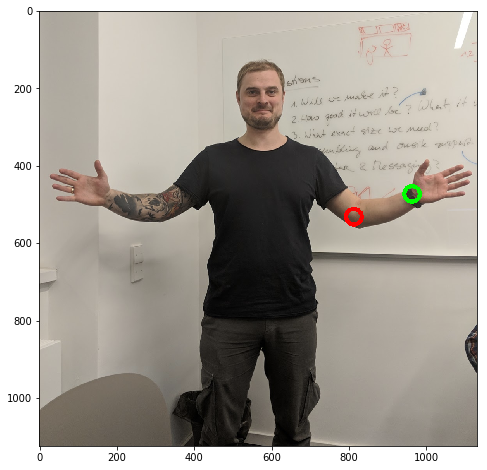

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(img[:,:,::-1])